# Определение перспективного тарифа для телеком компании

**Цель**: Определить выгодный тарифный план для корректировки рекламного бюджета.

**Выборка**. Данные 500 пользователей тарифных планов «Смарт» и «Ультра»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Примечание**: «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт:

* Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. 
* Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

##  Обзор данных

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np    
from scipy import stats as st
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [26]:
df_users = pd.read_csv('/datasets/users.csv')
df_calls = pd.read_csv('/datasets/calls.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')

## Предобработка данных

In [27]:
#Напишем функцию для получения первичной информации о датафрейме
def first_look(df):
    print('---------------------------Первые 5 строк----------------------------')
    display(df.head())
    print(' ')
    print(' ')
    print('--------------Общая информация--------------')
    print(' ')
    print(df.info())
    print(' ')
    print(' ')
    print('-------------Пропуски------------- ')
    count=0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
    print(' ')
    print(' ')
    print('-------------Дубликаты------------ ')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    print(' ')          

Рассмотрим таблицу **df_users**

In [28]:
first_look(df_users)

---------------------------Первые 5 строк----------------------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
 
 
-------------Пропуски------------- 
churn_date  -  462 пропусков
 
 
-------------Дубликаты------------ 
Дубликатов НЕТ
 


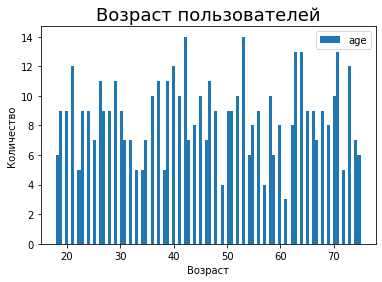

In [29]:
df_users.plot(kind='hist', y='age', bins=100)
plt.title('Возраст пользователей', fontsize=18)
plt.xlabel('Возраст')
plt.ylabel('Количество')

plt.show()

В таблице 500 строк и 8 столбцов. Пропуски только в столбце churn_date, в котором по условию, если есть пропуски, то тариф ещё действовал на момент выгрузки данных. В столбцах churn_date и reg_date изменим тип на datetime

In [30]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Рассмотрим таблицу **df_calls**

In [31]:
first_look(df_calls)

---------------------------Первые 5 строк----------------------------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
 
 
-------------Пропуски------------- 
Пропусков НЕТ
 
 
-------------Дубликаты------------ 
Дубликатов НЕТ
 


В таблице 202607 строк и 4 столбца, пропуски отсутствуют. Столбец call_date переведём в datetime. По условию "Мегалайн" всегда округляет секунды до минуты, поэтому обработаем столбец duration и переведём его в int

In [32]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_calls['duration'] = df_calls['duration'].astype('int')
df_calls.info()
df_calls.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
98677,1251_39,2018-08-21,9,1251
71389,1178_149,2018-05-31,6,1178
2847,1007_50,2018-07-27,16,1007
146106,1372_284,2018-07-03,6,1372
22792,1058_161,2018-11-20,6,1058
113043,1290_221,2018-12-08,4,1290
132939,1341_169,2018-12-16,0,1341
114770,1294_110,2018-05-05,13,1294
70094,1175_243,2018-12-26,1,1175
112702,1289_560,2018-11-02,15,1289


<div class="alert alert-block alert-info">
<b>💾 Fixed:</b> 
Добавлена гистограмма:

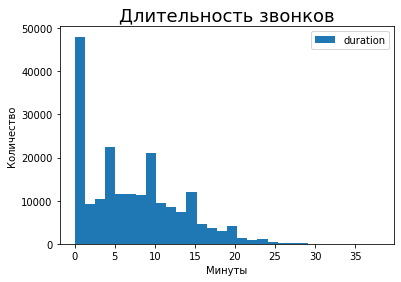

In [33]:
df_calls.plot(kind='hist', y='duration', bins=30)
plt.title('Длительность звонков', fontsize=18)
plt.xlabel('Минуты')
plt.ylabel('Количество')

plt.show()

In [34]:
df_calls['duration'].value_counts()

0     39613
7     11510
6     11457
5     11411
8     11272
9     10973
4     10918
3     10362
10    10186
11     9385
2      9194
12     8448
1      8402
13     7486
14     6554
15     5505
16     4551
17     3671
18     2984
19     2411
20     1806
21     1304
22      975
23      720
24      468
25      363
26      257
27      151
28      104
29       56
30       39
31       30
32       17
33       10
35        5
34        3
36        2
37        2
38        2
Name: duration, dtype: int64

Очень много значений с нулевой продолжительностью звонка - 39613. По условию это не ошибки, а пропущенные звонки, оставляем как есть. 

Рассмотрим таблицу **df_messages**

In [35]:
first_look(df_messages)

---------------------------Первые 5 строк----------------------------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
 
 
-------------Пропуски------------- 
Пропусков НЕТ
 
 
-------------Дубликаты------------ 
Дубликатов НЕТ
 


В таблице 123036 строк и 3 столбца, пропуски отсутствуют. Столбец message_date переведём в datetime.

In [36]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Рассмотрим таблицу **df_internet**

In [37]:
first_look(df_internet)

---------------------------Первые 5 строк----------------------------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,1052.810,2018-09-07,1000
2,2,1000_2,1197.260,2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
 
 
-------------Пропуски------------- 
Пропусков НЕТ
 
 
-------------Дубликаты------------ 
Дубликатов НЕТ
 


В таблице 149396 строк и 5 столбцов(в описании приведено только 4), пропуски отсутствуют. Посколько столбца Unnamed:0 нет в описании и его значения дублируют индексы, удалим его. Столбец session_date переведём в datetime. Значения в mb_used округлим по условию в большую сторону до целых и поменяем тип на int.

In [38]:
df_internet.drop('Unnamed: 0', axis=1, inplace=True)
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['mb_used'] = df_internet['mb_used'].astype('int')
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112,2018-11-25,1000
1,1000_1,1052,2018-09-07,1000
2,1000_2,1197,2018-06-25,1000
3,1000_3,550,2018-08-22,1000
4,1000_4,302,2018-09-24,1000


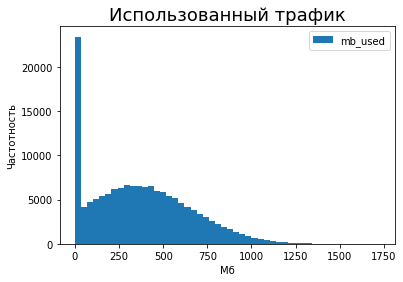

In [39]:
df_internet.plot(kind='hist', y='mb_used', bins=50)
plt.title('Использованный трафик', fontsize=18)
plt.xlabel('Мб')
plt.ylabel('Частотность')

plt.show()

In [40]:
df_internet.query('mb_used == 0')

,id,mb_used,session_date,user_id
11,1000_11,0,2018-08-28,1000
38,1000_38,0,2018-11-27,1000
46,1000_46,0,2018-06-30,1000
67,1000_67,0,2018-06-16,1000
72,1000_72,0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0,2018-12-11,1499
149381,1499_142,0,2018-11-01,1499
149383,1499_144,0,2018-11-27,1499
149386,1499_147,0,2018-10-21,1499


Очень много значений = 0 в объёме потраченного за сессию интернет-трафика, но поскольку при агрегировании трафика, мы будем суммировать мегабайты, эти нули не внесут отрицательного эффекта.

Рассмотрим таблицу **df_tariffs**

In [41]:
first_look(df_tariffs)

---------------------------Первые 5 строк----------------------------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
 
 
-------------Пропуски------------- 
Пропусков НЕТ
 
 
-------------Дубликаты------------ 
Дубликатов НЕТ
 


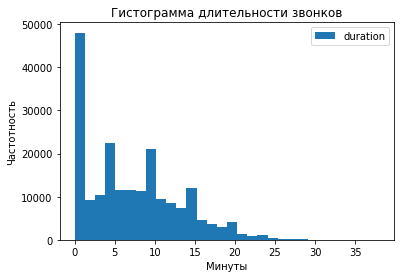

In [42]:
# Гистограмма длительности звонков. #ревьюер_код_ит

df_calls.plot(kind='hist', y='duration', bins=30)
plt.title('Гистограмма длительности звонков')
plt.xlabel('Минуты')
plt.ylabel('Частотность')

plt.show()

Корректная таблица.

### Подсчитаем значения для каждого пользователя 

**Количество сделанных звонков и израсходованных минут по месяцам**

In [43]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls = df_calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
df_calls.columns = ['user_id', 'month', 'calls', 'min']
display(df_calls.head())

,user_id,month,calls,min
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


**Количество отправленных сообщений по месяцам**

In [44]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
df_messages.columns = ['user_id', 'month', 'mes']
display(df_messages.head())

,user_id,month,mes
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Объём израссходованного интернет трафика по месяцам**

In [45]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
df_internet.columns = ['user_id', 'month', 'mb']
display(df_internet.head())

,user_id,month,mb
0,1000,5,2252
1,1000,6,23213
2,1000,7,13988
3,1000,8,14043
4,1000,9,14556


**Объединим данные в одной таблице**

In [46]:
abonents1 = df_users.loc[:,['user_id', 'city', 'tariff', 'first_name', 'last_name']]
abonents2 = pd.merge(df_calls, df_messages, how='outer', on=['user_id', 'month']) 
abonents3 = pd.merge(abonents2, df_internet, how='outer', on=['user_id', 'month'])
basa_abonents = pd.merge(abonents3, abonents1, how='outer', on=['user_id'])
basa_abonents = basa_abonents[['user_id', 'first_name', 'last_name', 'tariff', 'city', 'month', 'calls', 'min', 'mes', 'mb']]
display(basa_abonents.sample(5))
print('Количество абонентов в базе:', basa_abonents['user_id'].nunique())
print('')
basa_abonents.info()

,user_id,first_name,last_name,tariff,city,month,calls,min,mes,mb
3078,1481,Клавдия,Чижова,smart,Москва,11.000,44.000,297.000,19.000,19899.000
1192,1188,Габриэль,Соколов,smart,Санкт-Петербург,4.000,3.000,35.000,5.000,8908.000
2874,1453,Кузьма,Акуленко,ultra,Москва,11.000,123.000,973.000,57.000,24027.000
1129,1178,Наталья,Жарова,smart,Москва,12.000,76.000,611.000,18.000,15175.000
3169,1498,Всеволод,Акимчин,smart,Владикавказ,8.000,57.000,400.000,62.000,24206.000


Количество абонентов в базе: 500

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     3216 non-null   int64  
 1   first_name  3216 non-null   object 
 2   last_name   3216 non-null   object 
 3   tariff      3216 non-null   object 
 4   city        3216 non-null   object 
 5   month       3214 non-null   float64
 6   calls       3174 non-null   float64
 7   min         3174 non-null   float64
 8   mes         2717 non-null   float64
 9   mb          3203 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 276.4+ KB


In [47]:
basa_abonents.isna().sum()

user_id         0
first_name      0
last_name       0
tariff          0
city            0
month           2
calls          42
min            42
mes           499
mb             13
dtype: int64

Есть пропуски в 'calls', 'min', 'mes' и 'mb', т.к. количество небольшое, заполним их '0'. 

In [48]:
basa_abonents.loc[:,['calls', 'min', 'mes', 'mb']] = basa_abonents.loc[:,['calls', 'min', 'mes', 'mb']].fillna(0)

In [49]:
basa_abonents['month'].isna()
display(basa_abonents.tail())

,user_id,first_name,last_name,tariff,city,month,calls,min,mes,mb
3211,1489,Павел,Гончаров,smart,Санкт-Петербург,10.000,0.000,0.000,21.000,19538.000
3212,1489,Павел,Гончаров,smart,Санкт-Петербург,11.000,0.000,0.000,20.000,17471.000
3213,1489,Павел,Гончаров,smart,Санкт-Петербург,12.000,0.000,0.000,35.000,17298.000
3214,1128,Ксения,Агаева,ultra,Волжский,NaN,0.000,0.000,0.000,0.000
3215,1371,Ириней,Трофимов,smart,Омск,NaN,0.000,0.000,0.000,0.000


<div class="alert alert-block alert-info">
<b>💾 Fixed:</b> 
Агаеву и Трофимова не стоит включать в расчёт, т.к. 23 и 30 декабря соответственно они прекратили пользоваться тарифом, не пользуясь им.

In [50]:
# ревьюер_код_ит
basa_abonents[basa_abonents['month'].isna() == True]

,user_id,first_name,last_name,tariff,city,month,calls,min,mes,mb
3214,1128,Ксения,Агаева,ultra,Волжский,NaN,0.000,0.000,0.000,0.000
3215,1371,Ириней,Трофимов,smart,Омск,NaN,0.000,0.000,0.000,0.000


In [51]:
# ревьюер_код_ит
df_users.query('user_id == 1128 or user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


2 Абонента без данных о пользовании услугами(видимо подключившиеся в конце года). Заменим NaN на последний месяц.

In [52]:
basa_abonents.loc[:,['month']] = basa_abonents.loc[:,['month']].fillna(12)
basa_abonents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     3216 non-null   int64  
 1   first_name  3216 non-null   object 
 2   last_name   3216 non-null   object 
 3   tariff      3216 non-null   object 
 4   city        3216 non-null   object 
 5   month       3216 non-null   float64
 6   calls       3216 non-null   float64
 7   min         3216 non-null   float64
 8   mes         3216 non-null   float64
 9   mb          3216 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 276.4+ KB


**Определим помесячную выручку с каждого пользователя**

In [53]:
basa_abonents['gb'] = basa_abonents['mb'] / 1024
basa_abonents['gb'] = np.ceil(basa_abonents['gb']).astype('Int64')
basa_abonents.head()

,user_id,first_name,last_name,tariff,city,month,calls,min,mes,mb,gb
0,1000,Рафаил,Верещагин,ultra,Краснодар,5.000,22.000,159.000,22.000,2252.000,3
1,1000,Рафаил,Верещагин,ultra,Краснодар,6.000,43.000,172.000,60.000,23213.000,23
2,1000,Рафаил,Верещагин,ultra,Краснодар,7.000,47.000,340.000,75.000,13988.000,14
3,1000,Рафаил,Верещагин,ultra,Краснодар,8.000,52.000,408.000,81.000,14043.000,14
4,1000,Рафаил,Верещагин,ultra,Краснодар,9.000,58.000,466.000,57.000,14556.000,15


In [57]:
def revenue(basa_abonents):
    sum_min = basa_abonents['min']
    sum_mes = basa_abonents['mes']
    sum_gb = basa_abonents['gb']
    tariff = basa_abonents['tariff']
    if tariff == 'smart':
        if sum_min > 500:
            price_min = (sum_min - 500)*3 
        else:
            price_min = 0
        if sum_mes > 50:
            price_mes = (sum_mes-50)*3 
        else:
            price_mes = 0
        if sum_gb > 15:
            price_gb = (sum_gb - 15)*200 
        else:
            price_gb = 0
        return 550 + price_min + price_mes + price_gb  
    elif tariff == 'ultra':
        if sum_min > 3000:
            price_min = (sum_minut - 3000)*1 
        else:
            price_min = 0
        if sum_mes > 1000:
            price_mes = (sum_mes - 1000)*1 
        else:
            price_mes = 0
        if sum_gb > 30:
            price_gb = (sum_gb - 30)*150 
        else:
            price_gb = 0
        return  1950 + price_min + price_mes + price_gb  
    
basa_abonents['price_month'] =  basa_abonents.apply(revenue, axis=1)  
basa_abonents.head(20)

,user_id,first_name,last_name,tariff,city,month,calls,min,mes,mb,gb,price_month
0,1000,Рафаил,Верещагин,ultra,Краснодар,5.000,22.000,159.000,22.000,2252.000,3,1950.000
1,1000,Рафаил,Верещагин,ultra,Краснодар,6.000,43.000,172.000,60.000,23213.000,23,1950.000
2,1000,Рафаил,Верещагин,ultra,Краснодар,7.000,47.000,340.000,75.000,13988.000,14,1950.000
3,1000,Рафаил,Верещагин,ultra,Краснодар,8.000,52.000,408.000,81.000,14043.000,14,1950.000
4,1000,Рафаил,Верещагин,ultra,Краснодар,9.000,58.000,466.000,57.000,14556.000,15,1950.000
5,1000,Рафаил,Верещагин,ultra,Краснодар,10.000,57.000,350.000,73.000,14690.000,15,1950.000
6,1000,Рафаил,Верещагин,ultra,Краснодар,11.000,43.000,338.000,58.000,14745.000,15,1950.000
7,1000,Рафаил,Верещагин,ultra,Краснодар,12.000,46.000,333.000,70.000,9808.000,10,1950.000
8,1001,Иван,Ежов,smart,Москва,11.000,59.000,430.000,0.000,18405.000,18,1150.000
9,1001,Иван,Ежов,smart,Москва,12.000,63.000,414.000,0.000,14018.000,14,550.000


In [55]:
basa_abonents.query('user_id == 1001 & month == 11')

,user_id,first_name,last_name,tariff,city,month,calls,min,mes,mb,gb,price_month
8,1001,Иван,Ежов,smart,Москва,11.000,59.000,430.000,0.000,18405.000,18,1150.000


In [59]:
variance = np.var(basa_abonents['min'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', basa_abonents['min'].mean())

Дисперсия -  58610.62422636043
Отклонение -  242.09631188095457
Среднее -  450.9642412935323


## Анализ данных

In [64]:
#Функция для анализа поведения клиентов:
def hist_maker_and_table(df, name,x_1_smart,x_2_ultra):
    cd = df.groupby(df.tariff)[name]
    cd_desc = cd.describe(percentiles = [.01,.25,.75,.99])
    cd_desc['var']= [np.var(cd.get_group('smart'), ddof=1), np.var(cd.get_group('ultra'), ddof=1)]
    display(cd_desc)
    smart = df.query('tariff == "smart"')[name]
    ultra = df.query('tariff == "ultra"')[name]
    plt.figure(figsize=(10,6))
    plt.hist(smart, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'Смарт', density = False)
    plt.hist(ultra, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'Ультра', density = False)
    plt.axvline(cd_desc['mean'][0], color='blue', linestyle='dashed', linewidth=3, label='Среднее Смарт: {:.2f}'.format(cd_desc['mean'][0]))
    
    plt.axvline(cd_desc['mean'][1], color='orange', linestyle='dashed', linewidth=3, label='Среднее Ультра: {:.2f}'.format(cd_desc['mean'][1]))

    plt.axvline(x_1_smart, color='blue', linestyle='solid', linewidth=3, label='Включено в тариф Смарт')
    plt.axvline(x_2_ultra, color='orange', linestyle='solid', linewidth=3, label='Включено в тариф Ультра')
    plt.legend()
    plt.title('Распределение {} по месяцам для Смарт & Ультра'.format(name))

In [65]:
clients_month = basa_abonents.groupby(['tariff', 'month'])['min', 'mes', 'gb', 'price_month'].sum().reset_index()
smart_clients_month = clients_month.query(' tariff=="smart" ').reset_index(drop=True)
ultra_clients_month = clients_month.query(' tariff=="ultra" ').reset_index(drop=True)
display(smart_clients_month)
display(ultra_clients_month)

/tmp/ipykernel_36/2875906058.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clients_month = basa_abonents.groupby(['tariff', 'month'])['min', 'mes', 'gb', 'price_month'].sum().reset_index()


,tariff,month,min,mes,gb,price_month
0,smart,1.000,6931.000,620.000,297,24525.000
1,smart,2.000,17324.000,1397.000,687,48001.000
2,smart,3.000,30034.000,2453.000,1172,89476.000
3,smart,4.000,41119.000,3443.000,1524,107466.000
4,smart,5.000,54618.000,4762.000,2241,168649.000
5,smart,6.000,64885.000,5478.000,2614,197259.000
6,smart,7.000,82079.000,6784.000,3184,244814.000
7,smart,8.000,99045.000,7905.000,3925,309140.000
8,smart,9.000,111439.000,8746.000,4259,324386.000
9,smart,10.000,125284.000,9927.000,4955,399667.000


,tariff,month,min,mes,gb,price_month
0,ultra,1.000,3853.000,304.000,119,17550.000
1,ultra,2.000,7131.000,527.000,287,47400.000
2,ultra,3.000,18117.000,1195.000,651,74550.000
3,ultra,4.000,25191.000,1736.000,931,110100.000
4,ultra,5.000,34192.000,2536.000,1298,138000.000
5,ultra,6.000,40295.000,3505.000,1591,171300.000
6,ultra,7.000,49667.000,4536.000,1865,192600.000
7,ultra,8.000,54653.000,5183.000,2096,222750.000
8,ultra,9.000,62036.000,6013.000,2211,232650.000
9,ultra,10.000,68644.000,7187.000,2467,254100.000


С мая месяца наблюдается значительный рост выручки по тарифу **Smart**. К концу года выручка **Smart** выше выручки **Ultra** на 76%.

In [66]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,1286.234,816.489,550.000,550.000,550.000,1016.500,1750.000,3773.710,6770.000,666653.982
ultra,986.000,2069.422,374.506,1950.000,1950.000,1950.000,1950.000,1950.000,3772.500,4800.000,140254.386


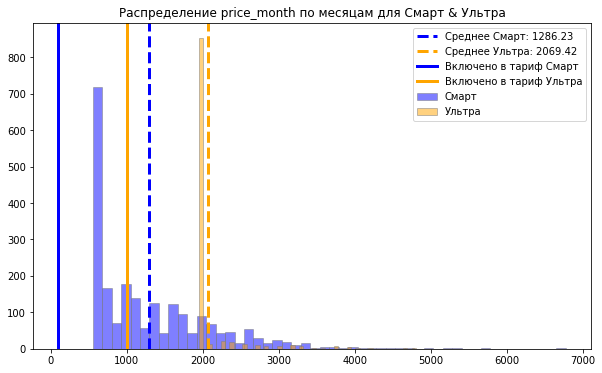

In [67]:
hist_maker_and_table(basa_abonents,'price_month',100,1000)

- Пользователи тарифа Смарт в среднем в месяц тратят меньше денег, чем пользователи тарифа Ультра, за счёт меньшей абоненсткой платы (1286 руб./2069 руб. ) .
- На тарифе Смарт пользователи очень часто доплачивают за трафик.
- Дисперсия и стандартное отклонение выше на тарифе Смарт, но пользователи этого тарифа часто не укладываются в установленные лимиты.
- Абонентская плата У тарифа Ультра выше, но его пользователи значительно реже доплачивают за услуги.

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,417.748,190.477,0.000,13.580,282.000,421.500,545.000,872.710,1435.000,36281.394
ultra,986.000,526.089,317.888,0.000,0.000,282.500,518.000,751.750,1291.050,1673.000,101052.494


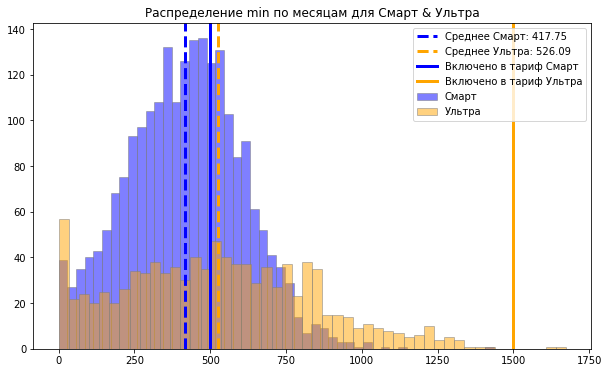

In [76]:
hist_maker_and_table(basa_abonents,'min',500,1500)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично! 👍:</b> 
    
Обожаю красивые графики.
    
Тем более, если они еще и информативны
</div>

- Пользователи тарифа Smart в среднем в месяц тратят меньше минут разговора, чем пользователи тарифа Ultra.
- На тарифе Smart пользователи часто не укладываются в лимиты и доплачивают за звонки.
- Дисперсия и стандартное отклонение выше на тарифе Ultra, но пользователи этого тарифа всегда укладываются в установленные лимиты.
- Максимальное число минут разговора в месяц более чем в 2 раза меньше заложенных в него 3000.

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,33.369,28.230,0.000,0.000,10.000,28.000,51.000,108.000,143.000,796.955
ultra,986.000,49.313,47.806,0.000,0.000,6.000,38.000,78.750,183.300,224.000,2285.417


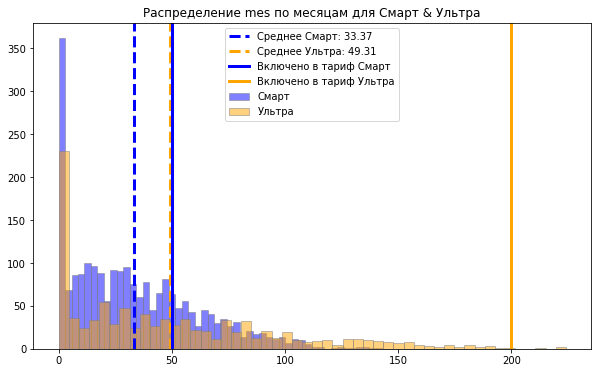

In [69]:
hist_maker_and_table(basa_abonents,'mes',50,200)

- Пользователи тарифа Smart в среднем в месяц пишут меньше сообщений, чем пользователи тарифа Ultra.
- На тарифе Ultra пользователи часто не укладываются в лимиты и доплачивают за отправленые сообщения.
- Дисперсия и стандартное отклонение выше на тарифе Ultra, но пользователи этого тарифа всегда укладываются в установленные лимиты отправки сообщений.
- Максимальное число сообщений в Ultra в месяц значительно меньше заложенных в него 1000.

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,16.301,5.748,0.000,2.000,13.000,17.000,20.000,29.000,38.000,33.036
ultra,986.000,19.459,9.862,0.000,0.000,12.000,19.000,27.000,42.150,49.000,97.256


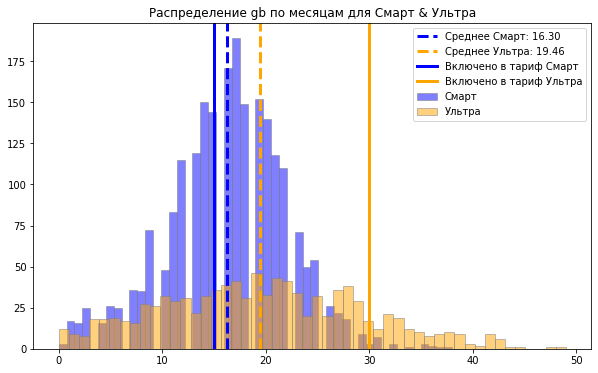

In [70]:
hist_maker_and_table(basa_abonents,'gb',15,30)

- Пользователи тарифа Smart в среднем в месяц тратят меньше трафика мобильного интернета, чем пользователи тарифа Ultra.
- На тарифе Smart пользователи очень часто не укладываются в лимит 15 Гб и доплачивают за трафик.
- Дисперсия и стандартное отклонение выше на тарифе Ultra, но пользователи этого тарифа часто не укладываются в установленные лимиты трафика.
- Максимальный трафик в Ultra значительно больше заложенных в него 30 Гб.

**Анализ тарифа "Ultra"**

In [71]:
ultra_clients_month.describe()

,month,min,mes,gb,price_month
count,12.000,12.000,12.000,12.000,12.000
mean,6.500,43227.000,4051.917,1598.917,170037.500
std,3.606,26050.945,2838.549,949.524,92998.976
min,1.000,3853.000,304.000,119.000,17550.000
25%,3.750,23422.500,1600.750,861.000,101212.500
50%,6.500,44981.000,4020.500,1728.000,181950.000
75%,9.250,63688.000,6306.500,2275.000,238012.500
max,12.000,82400.000,8425.000,3018.000,299250.000


In [72]:
for values in ['min', 'mes', 'gb', 'price_month']:
    variance = np.var(ultra_clients_month[values], ddof=1)
    print('Для:', values)
    print('--------------------------')
    print('Дисперсия - ', variance)
    print('Стандартное отклонение - ', np.sqrt(variance))
    print('Среднее - ', ultra_clients_month[values].mean())
    print('')  
    print('Выручка за 2018 год: ',ultra_clients_month['price_month'].sum())

Для: min
--------------------------
Дисперсия -  678651712.3636364
Стандартное отклонение -  26050.944557993218
Среднее -  43227.0

Выручка за 2018 год:  2040450.0
Для: mes
--------------------------
Дисперсия -  8057360.628787881
Стандартное отклонение -  2838.549035825853
Среднее -  4051.9166666666665

Выручка за 2018 год:  2040450.0
Для: gb
--------------------------
Дисперсия -  901595.1742424242
Стандартное отклонение -  949.5236564943625
Среднее -  1598.9166666666667

Выручка за 2018 год:  2040450.0
Для: price_month
--------------------------
Дисперсия -  8648809602.272728
Стандартное отклонение -  92998.97635067135
Среднее -  170037.5

Выручка за 2018 год:  2040450.0


**Анализ тарифа "Smart"**

In [73]:
smart_clients_month.describe()

,month,min,mes,gb,price_month
count,12.000,12.000,12.000,12.000,12.000
mean,6.500,77631.417,6201.083,3029.333,239025.083
std,3.606,49912.745,3790.990,1920.428,161374.183
min,1.000,6931.000,620.000,297.000,24525.000
25%,3.750,38347.750,3195.500,1436.000,102968.500
50%,6.500,73482.000,6131.000,2899.000,221036.500
75%,9.250,114900.250,9041.250,4433.000,343206.250
max,12.000,161275.000,12130.000,6127.000,531515.000


In [74]:
for values in ['min', 'mes', 'gb']:
    variance = np.var(smart_clients_month[values], ddof=1)
    print('Для:', values)
    print('--------------------------')
    print('Дисперсия - ', variance)
    print('Стандартное отклонение - ', np.sqrt(variance))
    print('Среднее - ', smart_clients_month[values].mean())
    print('') 
    print('Выручка за 2018 год: ',smart_clients_month['price_month'].sum())

Для: min
--------------------------
Дисперсия -  2491282105.7196965
Стандартное отклонение -  49912.74492271184
Среднее -  77631.41666666667

Выручка за 2018 год:  2868301.0
Для: mes
--------------------------
Дисперсия -  14371602.81060606
Стандартное отклонение -  3790.989687483476
Среднее -  6201.083333333333

Выручка за 2018 год:  2868301.0
Для: gb
--------------------------
Дисперсия -  3688044.96969697
Стандартное отклонение -  1920.4283297475515
Среднее -  3029.3333333333335

Выручка за 2018 год:  2868301.0


## Проверка гипотез

### Средняя выручка пользователей тарифов Ultra и Smart различаются

**Н0** - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **равны**, т.е. средние значения равны.

**Н1** - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **не равны**, т.е. средние значения не равны.

Дисперсии выборок были расчитаны выше, они отличаются более чем на 5%

In [44]:
basa_ultra = basa_abonents.query('tariff == "ultra"')['price_month'] 
basa_smart = basa_abonents.query('tariff == "smart"')['price_month'] 
results = st.ttest_ind( basa_ultra, basa_smart)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотез')

p-значение:  1.5359815168867794e-162
Отвергаем нулевую гипотезу


p-значение достаточно мало, что дает основание отвергнуть предположение об отсутствии различий между выручками у разных тарифных планов, т.е. маловероятна случайность результатов теста гипотезы.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Н0** - Средняя выручка пользователей из Москвы и пользователей из других регионов **равны**.

**Н1** - Средняя выручка пользователей из Москвы и пользователей из других регионов **не равны**.


In [45]:
basa_msk = basa_abonents.query('city == "Москва"')['price_month']
basa_another_city = basa_abonents.query('city != "Москва"')['price_month']
results = st.ttest_ind(basa_msk, basa_another_city)
alpha = 0.05

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5318623146051247
Не получилось отвергнуть нулевую гипотезу


Средняя выручка пользователей из Москвы практически не отличается от выручки пользователей из других регионов, так как значение статистической  значимости больше критического уровня статистической значимости.

# Общий вывод

- За 2018 год выручка от 500 пользователей составила **4908751 рублей**. Из них тарифом **Смарт** пользуется 351(~70%) абонент и приносит приблизительно 60% выручки - **2868301 рублей**. Тарифом **Ультра** пользуется 149(~30%) абонентов и приносят приблизительно 40% выручки - **2040450 рублей**, . С мая месяца наблюдается значительный рост выручки по тарифу **Смарт**. К концу года выручка **Смарт** выше выручки **Ультра** на 76%.
- Хотя абонентская плата тарифа **Смарт** практически в 4 раза меньше чем у тарифа **Ультра**, пользователи **Смарт** значительно превышают лимиты по минутам, сообщениям и трафику интернет(средний трафик  по месяцам больше назначенного лимита), что приводит к серьёзным переплатам сверх абонентской платы. Максимальные показатели выручки за месяц по тарифу **Смарт** - 6770 руб., по тарифу **Ультра** - 4800 руб. Использование сообщений СМС практически заканчивается на значении ~ 100 шт., что превышает лимит **Смарт**(50-СМС) и хорошо вписывается в тариф **Ультра**(1000-СМС).
- **В итоге проанализировав данные из выборки по 500 абонентам в 2018 году, мы выяснили, что 70% потребителей делают 60% всей выручки, пользуясь тарифом "Смарт". Если оператор "Мегалайн" не собирается вводить новый(промежуточный между Смарт и Ультра) тариф, то следует вложиться в рекламный бюджет тарифа "Смарт", т.к. он пользуется большей популярностью и приносит больше денег.**